<h1><center>Классификация текстов</center></h1>

Сегодня мы подробнее познакомимся с задачей классификации текстов на два или более классов.

У нас есть [набор данных отзывов на фильмы IMDB](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), который часто используют при разработке и оценке моделей классификации текстов. Каждый из отзывов в наборе данных имеет свою оценку: является ли он позитивным или негативным.

**Цель:** Используя данные отзывов IMDB, построить модель, которая на основе текста отзыва сможет определять, относится ли он к позитивнму или к негативному классу.

## План работы
* Подготовка данных
* Классификация с помощью Word2Vec:
    * Обучение модели Word2Vec
    * Построение векторов для текстов через среднее векторов слов
    * Построение векторов для текстов через средневзвешенное векторов слов
* Классификация с помощью FastText
* Классификация с помощью сверточной нейронной сети (CNN)

## Подготовка данных



Для обучения нейросетевых моделей (далее) мы будем использовать популярный фреймворк [PyTorch](https://pytorch.org/).

В предположении, что PyTorch уже установлен, поставим дополнительные модули (torchvision и torchtext) и загрузим модель для токенизации:

In [1]:
!pip install torchvision

In [2]:
!pip install torchtext

Загрузим датасет IMDB из torchtext, это будет удобно для дальнейшего использования этих данных при обучении нейронной сети.

In [3]:
import numpy as np
import torch
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,classification_report,confusion_matrix
from torchtext import data
from torchtext import datasets
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter,defaultdict
%matplotlib inline
import seaborn as sns

print(torch.__version__)

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField()

train_src, test = datasets.IMDB.splits(TEXT, LABEL)

1.6.0
downloading aclImdb_v1.tar.gz


Разделим данные на обучаующую и тестовую выборку и преобразуем их в формат, удобный для построения классических моделей машинного обучения.

In [5]:
X_train = [example.text for example in train_src]
y_train = [example.label for example in train_src]

X_test = [example.text for example in test]
y_test = [example.label for example in test]


In [8]:
from collections import Counter

print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

train_counter = Counter(y_train)
test_counter = Counter(y_test)

print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))
print ("{0} positive and {1} negative examples in test".format(test_counter['pos'],test_counter['neg']))

total train examples 25000
total test examples 25000
12500 positive and 12500 negative examples in test
12500 positive and 12500 negative examples in test


Можно видеть, что классы сбалансированы: количество позитивных и негативных отзывов совпадают.

Посмотрим на примеры позитивного и негативного отзыва.

In [10]:
print("Negative example:\n{0}\n\n".format(' '.join(X_train[0])))
print("Positive example:\n{0}\n\n".format(' '.join(X_train[-1])))

Negative example:
For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem . Imagine a movie where Joe Piscopo is actually funny ! Maureen Stapleton is a scene stealer . The Moroni character is an absolute scream . Watch for Alan " The Skipper " Hale jr . as a police Sgt .


Positive example:
Not that I dislike childrens movies , but this was a tearjerker with few redeeming qualities . M.J. Fox was the perfect voice for Stuart and the rest of the talent was wasted . Hugh Laurie can be amazingly funny , but is not given the chance in this movie . It´s sugar - coated sugar and would hardly appeal to anyone over 7 years of age . See Toy Story , Monsters Inc. or Shrek instead . 3/10




## Классификация с помощью Word2Vec

Подробно языковая модель *Word2Vec* была рассмотрена на предыдущей неделе курса.

Здесь мы будем использовать эту модель для получения векторных представлений слов.

In [8]:
from gensim.models import Word2Vec
# # model = Word2Vec(X_train, size=100, window=5, min_count=5, workers=4)
# # model.save("word2vec.model")

In [9]:
w2v_model = Word2Vec.load("word2vec.model")

Чтобы решить задачу классификации текстов, нам нужно каждому тексту поставить в соответствие вектор.

Реализуем класс *MeanEmbeddingVectorizer*, с помощью которого будем получать вектора для текстов отзывов на основе векторов слов.
Вектор каждого текста будет равен среднему векторов входящих в него слов.

In [10]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

Попробуем также немного другой подход $-$ будем получать вектор для текста как средневзвешенное векторов входящих в него слов с весами *tf-idf*.

Для этого реализуем класс *TfidfEmbeddingVectorizer*.

In [11]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(list(word2vec.values())[0])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Преобразуем модель Word2Vec в словарь для дальнейшего использования для векторизации текстов.

In [26]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))

Для классификации будем использовать модель [случайного леса](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из scikit-learn.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rfc_w2v = Pipeline([
    ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])
rfc_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("extra trees", RandomForestClassifier(n_estimators=20))])

In [17]:
%time rfc_w2v.fit(X_train,y_train)
pred = rfc_w2v.predict(X_test)

CPU times: user 8.03 s, sys: 56.2 ms, total: 8.09 s
Wall time: 8.12 s


Построим отчет по предсказаниям модели (с помощью MeanEmbeddingVectorizer) на тестовой выборке. Выведем точность (precision), полноту (recall) и f1-меру для позитивного и негативного классов, а также количество объектов каждого класса (support) в тестовой выборке.

Precision:   0.60
Recall:   0.60
F1-measure:   0.60
Accuracy:   0.60
              precision    recall  f1-score   support

         neg       0.59      0.67      0.63     12500
         pos       0.62      0.53      0.57     12500

    accuracy                           0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000



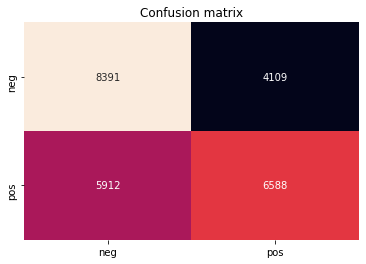

In [19]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

В данном случае классы сбалансированы (количество объектов позитивного и негативного классов совпадают), поэтому в качестве метрики качества можно использовать *accuracy*.

In [20]:
%time rfc_w2v_tfidf.fit(X_train,y_train)
pred = rfc_w2v_tfidf.predict(X_test)

CPU times: user 1min 44s, sys: 1.19 s, total: 1min 45s
Wall time: 1min 45s


Теперь выведем результаты работы классификатора на признаках из *TfidfEmbeddingVectorizer*.

Precision:   0.62
Recall:   0.62
F1-measure:   0.62
Accuracy:   0.62
              precision    recall  f1-score   support

         neg       0.61      0.68      0.64     12500
         pos       0.64      0.56      0.60     12500

    accuracy                           0.62     25000
   macro avg       0.62      0.62      0.62     25000
weighted avg       0.62      0.62      0.62     25000



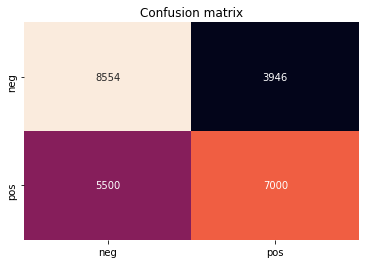

In [21]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что при использовании *TfidfEmbeddingVectorizer* метрика Accuracy немного увеличилась по сравнению c *MeanEmbeddingVectorizer* $-$ с 0.60 до 0.62.

## Классификация с помощью FastText

Теперь попробуем классифицировать тексты с помощью другой языковой модели [FastText](https://github.com/facebookresearch/fasttext), которая также была описана в предыдущем занятии.

Чтобы использовать модель, подготовим для нее данные, записав тексты и их метки классов в файлы data.train.txt и text.txt

In [27]:
import fasttext

N = -1

with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ ' '.join(X_train[i]) + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + ' '.join(X_test[i]) + '\n')

Будем использовать встроенную в fasttext модель классификации (логистическая регрессия) с помощью метода train_supervised.

In [28]:
classifier = fasttext.train_supervised('data.train.txt')#, 'model')
result = classifier.test('test.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.86784
R@1: 0.86784
Number of examples: 25000


Precision:   0.87
Recall:   0.87
F1-measure:   0.87
Accuracy:   0.87
              precision    recall  f1-score   support

         neg       0.89      0.83      0.86     12500
         pos       0.84      0.90      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



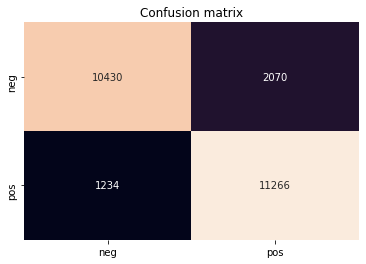

In [29]:
pred = classifier.predict([' '.join(x) for x in X_test])[0]
pred = [label[0].split("_")[-1] for label in pred]

print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))#[i[0] for i in pred]))
labels = rfc_w2v.classes_


sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Можно видеть, что качество классификации при использовании FastText существенно увеличилось по сравнению с моделях на основе Word2Vec.

## Классификация с использованием CNN

Теперь попробуем применить нейросетевой подход.

Построим сверточную нейронную сеть (CNN) для классификации документов на позитивный и негативный классы.

In [52]:
!pip install spacy

In [53]:
!python -m spacy download en
!python -m spacy download en_core_web_sm

In [54]:
import spacy

en_nlp = spacy.load('en_core_web_sm')

Попробуем обучить простую CNN на векторах слов. С учётом того, что в коллекции 100К уникальных слов, и векторы получатся достаточно громоздкие, урежем коллекцию до 25К слов, для всех прочих заведя токен unk (unknown). Кроме того, разобьём обучающую выборку на обучение и валидацию для настройки параметров.

In [56]:
import random
train, valid = train_src.split(random_state=random.seed(SEED))

In [57]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

Выше в словаре, помимо отсечения 25К наиболее частых слов, также появятся два специальных токена - unk и pad (padding).

Теперь создадим батчи, предварительно отсортировав тексты по длине, чтобы минимизировать вставки pad-токенов:

In [58]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Опишем функцию подсчёта accuracy, а также функции обучения и применения сети:

In [59]:
import torch.nn.functional as F

def binary_accuracy(preds, y):
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [60]:
def train_func(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        
        predictions = model(batch.text.cuda()).squeeze(1)

        loss = criterion(predictions.float(), batch.label.float().cuda())
        acc = binary_accuracy(predictions.float(), batch.label.float().cuda())
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [61]:
def evaluate_func(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text.cuda()).squeeze(1)

            loss = criterion(predictions.float(), batch.label.float().cuda())
            acc = binary_accuracy(predictions.float(), batch.label.float().cuda())

            epoch_loss += loss
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Начнём с подготовки данных:

In [62]:
TEXT.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train)


BATCH_SIZEBATCH_S  = 8

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Для создания свёрточного слоя воспользуемся nn.Conv2d, in_channels в нашем случае один (текст), out_channels -- это число число фильтров и размер ядер всех фильтров. Каждый фильтр будет иметь размерность [n x размерность вектора], где n - размер обрабатываемой n-граммы.

Важно, что предложения имели длину не меньше размера самого большого из используемых фильтров (здесь это не страшно, поскольку в используемых данных нет текстов, состоящих из пяти и менее слов).

In [63]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size]
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

Cоздадим модель и загрузим предобученные модели векторных представлений:


In [64]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [65]:
TEXT.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.4630, -0.1846,  0.2313,  ...,  0.2153,  0.0244,  0.4976],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1769, -0.4227, -0.0010,  ..., -0.6676, -0.0345,  0.3802]])

In [67]:
BATCH_SIZE  = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

Используя определённые ранее функции, запустим обучение с оптимизатором Adam и оценим качество на валидации и тесте:

In [68]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

model = model.cuda()

In [69]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_func(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_func(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01, Train Loss: 0.504, Train Acc: 74.32%, Val. Loss: 0.345, Val. Acc: 84.98%
Epoch: 02, Train Loss: 0.307, Train Acc: 86.99%, Val. Loss: 0.281, Val. Acc: 88.44%
Epoch: 03, Train Loss: 0.225, Train Acc: 91.10%, Val. Loss: 0.274, Val. Acc: 88.67%
Epoch: 04, Train Loss: 0.151, Train Acc: 94.68%, Val. Loss: 0.255, Val. Acc: 89.69%
Epoch: 05, Train Loss: 0.095, Train Acc: 96.85%, Val. Loss: 0.279, Val. Acc: 89.48%


In [70]:
test_loss , test_acc = evaluate_func(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.322, Test Acc: 87.97%


Можно видеть, что качество классификации после 5 эпох обучения стало немного выше, чем при использовании FastText.

## Итоги

На этом занятии мы рассмотрели задачу бинарной классификации текстов на примере отзывов IMDB.
Для решения этой задачи мы попробовали следующие модели:
1. Word2Vec + MeanEmbeddingVectorizer + RandomForest
2. Word2Vec + TfidfEmbediingVectorizer + RandomForest
3. FastText со встроенным классификатором
4. Glove + CNN

Наилучшее качество показала нейросетевая модель CNN.